In [0]:
import argparse
import os
import torch
import torch.nn as nn
from PIL import Image
from os.path import basename
from os.path import splitext
from torchvision import transforms
from torchvision.utils import save_image
from function import calc_mean_std, normal, coral
import net

def test_transform(size, crop):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    if crop:
        transform_list.append(transforms.CenterCrop(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

def style_transfer(vgg, decoder, sa_module, content, style, alpha=1,
                   interpolation_weights=None):
    assert (0.0 <= alpha <= 1.0)
    content_f, style_f=feat_extractor(vgg, content, style)
    Fccc = sa_module(content_f,content_f)

    if interpolation_weights:
        _, C, H, W = Fccc.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = sa_module(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        Fccc=Fccc[0:1]
    else:
        feat = sa_module(content_f, style_f)
    feat = feat * alpha + Fccc * (1 - alpha)
    
    return decoder(feat)
  
def feat_extractor(vgg, content, style):
  norm = nn.Sequential(*list(vgg.children())[:1])
  enc_1 = nn.Sequential(*list(vgg.children())[:4])  # input -> relu1_1
  enc_2 = nn.Sequential(*list(vgg.children())[4:11])  # relu1_1 -> relu2_1
  enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
  enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
  enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

  norm.to(device)
  enc_1.to(device)
  enc_2.to(device)
  enc_4.to(device)
  enc_5.to(device)
  
  Content4_1 = enc_4(enc_3(enc_2(enc_1(content))))
  Content5_1 = enc_5(Content4_1)

  Style4_1 = enc_4(enc_3(enc_2(enc_1(style))))
  Style5_1 = enc_5(Style4_1)

  content_f=[Content4_1,Content5_1]
  style_f=[Style4_1,Style5_1]
  
  return content_f, style_f

content="./drive/My Drive/SANET/content/sailboat.jpg"
style="./drive/My Drive/SANET/style/star_night.jpg"
vgg_path='./drive/My Drive/SANET/experiments/vgg_normalised.pth'
decoder_path='./drive/My Drive/SANET/experiments/decoder_iter_100000.pth'
transform_path='./drive/My Drive/SANET/experiments/sa_module_iter_100000.pth'
# Additional options
content_size=512
style_size=512
crop='store_true'
save_ext='.jpg'
output_path='./drive/My Drive/SANET/output'

# Advanced options
preserve_color='store_true'
alpha=1
style_interpolation_weights=''

preserve_color=False

do_interpolation = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Either --content or --contentDir should be given.
assert (content or content_dir)
# Either --style or --styleDir should be given.
assert (style or style_dir)

if content:
    content_paths = [content]
else:
    content_paths = [os.path.join(content_dir, f) for f in
                     os.listdir(content_dir)]

if style:
    style_paths = style.split(',')
    if len(style_paths) == 1:
        style_paths = [style]
    else:
        do_interpolation = True
        assert (style_interpolation_weights != ''), \
            'Please specify interpolation weights'
        weights = [int(i) for i in style_interpolation_weights.split(',')]
        interpolation_weights = [w / sum(weights) for w in weights]
else:
    style_paths = [os.path.join(style_dir, f) for f in
                   os.listdir(style_dir)]

if not os.path.exists(output_path):
    os.mkdir(output_path)

decoder = net.decoder
vgg = net.vgg
network=net.Net(vgg,decoder)
sa_module = network.sa_module


decoder.eval()
sa_module.eval()
vgg.eval()

decoder.load_state_dict(torch.load(decoder_path))
sa_module.load_state_dict(torch.load(transform_path))
vgg.load_state_dict(torch.load(vgg_path))

norm = nn.Sequential(*list(vgg.children())[:1])
enc_1 = nn.Sequential(*list(vgg.children())[:4])  # input -> relu1_1
enc_2 = nn.Sequential(*list(vgg.children())[4:11])  # relu1_1 -> relu2_1
enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

norm.to(device)
enc_1.to(device)
enc_2.to(device)
enc_3.to(device)
enc_4.to(device)
enc_5.to(device)
sa_module.to(device)
decoder.to(device)


content_tf = test_transform(content_size, crop)
style_tf = test_transform(style_size, crop)

for content_path in content_paths:
  if do_interpolation:  # one content image, N style image
      style = torch.stack([style_tf(Image.open(p)) for p in style_paths])
      content = content_tf(Image.open(content_path)) \
          .unsqueeze(0).expand_as(style)
      style = style.to(device)
      content = content.to(device)
      with torch.no_grad():
          output = style_transfer(vgg, decoder, sa_module, content, style,
                                  alpha, interpolation_weights)
      output = output.cpu()
      output_name = '{:s}/{:s}_interpolation_{:s}'.format(
          output_path, splitext(basename(content_path))[0], save_ext)
      save_image(output, output_name)

  else:  # process one content and one style
      for style_path in style_paths:
          content = content_tf(Image.open(content_path))
          style = style_tf(Image.open(style_path))
          if preserve_color:
              style = coral(style, content)
          style = style.to(device).unsqueeze(0)
          content = content.to(device).unsqueeze(0)
          with torch.no_grad():
              output = style_transfer(vgg, decoder, sa_module, content, style,
                                      alpha)
          output = output.cpu()

          output_name = '{:s}/{:s}_stylized_{:s}{:s}'.format(
              output_path, splitext(basename(content_path))[0],
              splitext(basename(style_path))[0], save_ext
          )
          save_image(output, output_name)

[]

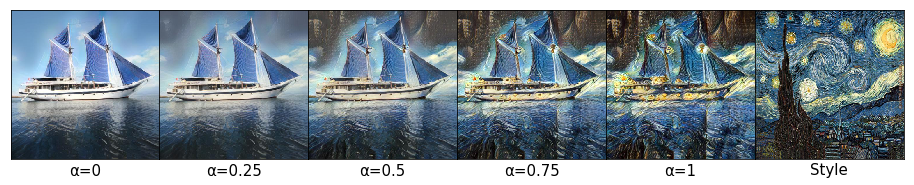

In [94]:
import matplotlib.pyplot as plt
from PIL import Image

fig=plt.figure(figsize=(16,5))
fig.subplots_adjust(hspace=0, wspace=0)
axes = fig.subplots(1, 6)

axes[0].imshow(Image.open('./drive/My Drive/SANET/output/sailboat_stylized_star_night.jpg').resize((512,512)))
axes[0].set_xlabel("\u03B1=0", fontsize=15)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(Image.open('./drive/My Drive/SANET/output/sailboat_stylized1_star_night.jpg').resize((512,512)))
axes[1].set_xlabel("\u03B1=0.25", fontsize=15)
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].imshow(Image.open('./drive/My Drive/SANET/output/sailboat_stylized2_star_night.jpg').resize((512,512)))
axes[2].set_xlabel("\u03B1=0.5", fontsize=15)
axes[2].set_xticks([])
axes[2].set_yticks([])

axes[3].imshow(Image.open('./drive/My Drive/SANET/output/sailboat_stylized3_star_night.jpg').resize((512,512)))
axes[3].set_xlabel("\u03B1=0.75", fontsize=15)
axes[3].set_xticks([])
axes[3].set_yticks([])

axes[4].imshow(Image.open('./drive/My Drive/SANET/output/sailboat_stylized4_star_night.jpg').resize((512,512)))
axes[4].set_xlabel("\u03B1=1", fontsize=15)
axes[4].set_xticks([])
axes[4].set_yticks([])

axes[5].imshow(Image.open('./drive/My Drive/SANET/style/star_night.jpg').resize((512,512)))
axes[5].set_xlabel("Style", fontsize=15)
axes[5].set_xticks([])
axes[5].set_yticks([])

(-0.5, 511.5, 511.5, -0.5)

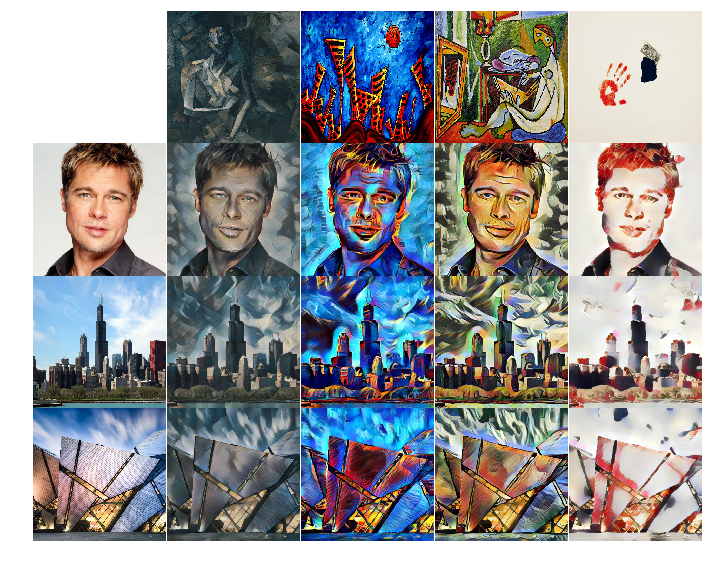

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

fig=plt.figure(figsize=(12,9.75))
fig.subplots_adjust(hspace=0, wspace=0)
axes = fig.subplots(4, 5)

axes[0,0].axis('off')
axes[0,1].imshow(Image.open('./drive/My Drive/SANET/style/picasso_seated_nude_hr.jpg').resize((512,512)))
axes[0,1].axis('off')
axes[0,2].imshow(Image.open('./drive/My Drive/SANET/style/city.jpg').resize((512,512)))
axes[0,2].axis('off')
axes[0,3].imshow(Image.open('./drive/My Drive/SANET/style/la_muse.jpg').resize((512,512)))
axes[0,3].axis('off')
axes[0,4].imshow(Image.open('./drive/My Drive/SANET/style/impronte_d_artista.jpg').resize((512,512)))
axes[0,4].axis('off')
axes[1,0].imshow(Image.open('./drive/My Drive/SANET/content/brad_pitt.jpg').resize((512,512)))
axes[1,0].axis('off')
axes[1,1].imshow(Image.open('./drive/My Drive/SANET/output/brad_pitt_stylized_picasso_seated_nude_hr.jpg'))
axes[1,1].axis('off')
axes[1,2].imshow(Image.open('./drive/My Drive/SANET/output/brad_pitt_stylized_city.jpg'))
axes[1,2].axis('off')
axes[1,3].imshow(Image.open('./drive/My Drive/SANET/output/brad_pitt_stylized_la_muse.jpg'))
axes[1,3].axis('off')
axes[1,4].imshow(Image.open('./drive/My Drive/SANET/output/brad_pitt_stylized_impronte_d_artista.jpg'))
axes[1,4].axis('off')
axes[2,0].imshow(Image.open('./drive/My Drive/SANET/content/chicago.jpg').resize((512,512)))
axes[2,0].axis('off')
axes[2,1].imshow(Image.open('./drive/My Drive/SANET/output/chicago_stylized_picasso_seated_nude_hr.jpg'))
axes[2,1].axis('off')
axes[2,2].imshow(Image.open('./drive/My Drive/SANET/output/chicago_stylized_city.jpg'))
axes[2,2].axis('off')
axes[2,3].imshow(Image.open('./drive/My Drive/SANET/output/chicago_stylized_la_muse.jpg'))
axes[2,3].axis('off')
axes[2,4].imshow(Image.open('./drive/My Drive/SANET/output/chicago_stylized_impronte_d_artista.jpg'))
axes[2,4].axis('off')
axes[3,0].imshow(Image.open('./drive/My Drive/SANET/content/modern.jpg').resize((512,512)))
axes[3,0].axis('off')
axes[3,1].imshow(Image.open('./drive/My Drive/SANET/output/modern_stylized_picasso_seated_nude_hr.jpg'))
axes[3,1].axis('off')
axes[3,2].imshow(Image.open('./drive/My Drive/SANET/output/modern_stylized_city.jpg'))
axes[3,2].axis('off')
axes[3,3].imshow(Image.open('./drive/My Drive/SANET/output/modern_stylized_la_muse.jpg'))
axes[3,3].axis('off')
axes[3,4].imshow(Image.open('./drive/My Drive/SANET/output/modern_stylized_impronte_d_artista.jpg'))
axes[3,4].axis('off')


[]

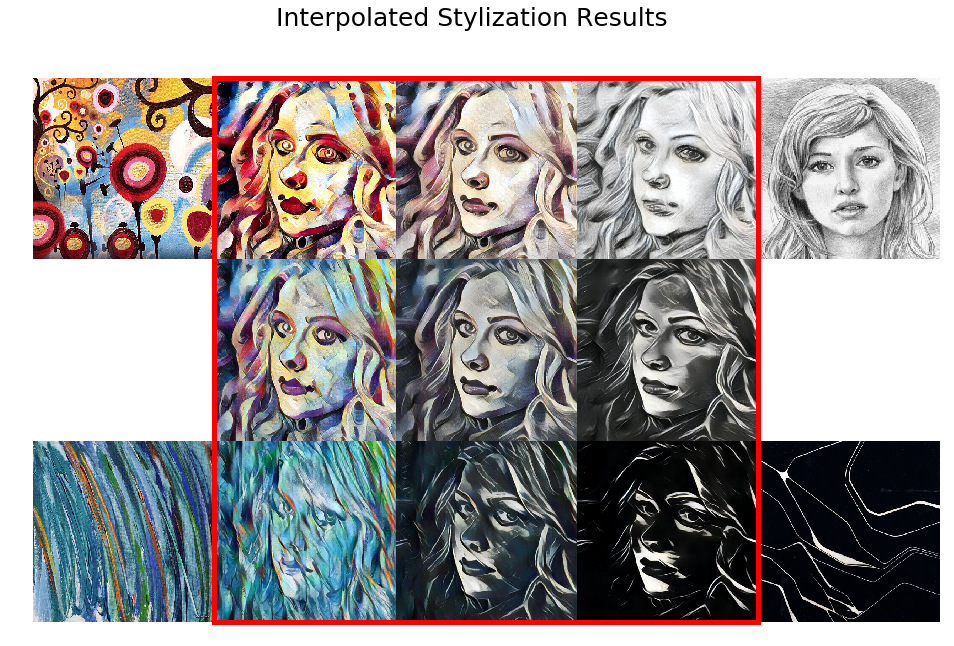

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
fig=plt.figure(figsize=(16.25,10))
fig.subplots_adjust(hspace=0, wspace=0)
axes = fig.subplots(3, 5)
fig.suptitle("Interpolated Stylization Results", fontsize=25)
axes[0,0].imshow(Image.open('./drive/My Drive/SANET/style/candy.jpg'))
axes[0,0].axis('off')

axes[0,1].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_1.jpg'))
axes[0,1].spines["right"].set_visible(False)
axes[0,1].spines["left"].set_linewidth(5)
axes[0,1].spines["left"].set_color('r')
axes[0,1].spines["bottom"].set_visible(False)
axes[0,1].spines["top"].set_linewidth(5)
axes[0,1].spines["top"].set_color('r')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

axes[0,2].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_2.jpg'))
axes[0,2].spines["right"].set_visible(False)
axes[0,2].spines["left"].set_visible(False)
axes[0,2].spines["top"].set_linewidth(5)
axes[0,2].spines["top"].set_color('r')
axes[0,2].spines["bottom"].set_visible(False)
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])


axes[0,3].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_3.jpg'))
axes[0,3].spines["right"].set_linewidth(5)
axes[0,3].spines["right"].set_color('r')
axes[0,3].spines["left"].set_visible(False)
axes[0,3].spines["top"].set_linewidth(5)
axes[0,3].spines["top"].set_color('r')
axes[0,3].spines["bottom"].set_visible(False)
axes[0,3].set_xticks([])
axes[0,3].set_yticks([])

axes[0,4].imshow(Image.open('./drive/My Drive/SANET/style/sketch.png'))
axes[0,4].spines["left"].set_linewidth(5)
axes[0,4].spines["left"].set_color('r')
axes[0,4].spines["right"].set_visible(False)
axes[0,4].spines["bottom"].set_visible(False)
axes[0,4].spines["top"].set_visible(False)
axes[0,4].set_xticks([])
axes[0,4].set_yticks([])

axes[1,0].axis('off')

axes[1,1].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_9.jpg'))
axes[1,1].spines["right"].set_visible(False)
axes[1,1].spines["left"].set_linewidth(5)
axes[1,1].spines["left"].set_color('r')
axes[1,1].spines["bottom"].set_visible(False)
axes[1,1].spines["top"].set_visible(False)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

axes[1,2].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_6.jpg'))
axes[1,2].axis('off')

axes[1,3].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_4.jpg'))
axes[1,3].spines["left"].set_visible(False)
axes[1,3].spines["right"].set_linewidth(5)
axes[1,3].spines["right"].set_color('r')
axes[1,3].spines["bottom"].set_visible(False)
axes[1,3].spines["top"].set_visible(False)
axes[1,3].set_xticks([])
axes[1,3].set_yticks([])

axes[1,4].axis('off')


axes[2,0].imshow(Image.open('./drive/My Drive/SANET/style/brushstrokes.jpg').resize((512,512)))
axes[2,0].axis('off')

axes[2,1].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_8.jpg'))
axes[2,1].spines["right"].set_visible(False)
axes[2,1].spines["left"].set_linewidth(5)
axes[2,1].spines["left"].set_color('r')
axes[2,1].spines["top"].set_visible(False)
axes[2,1].spines["bottom"].set_linewidth(5)
axes[2,1].spines["bottom"].set_color('r')
axes[2,1].set_xticks([])
axes[2,1].set_yticks([])

axes[2,2].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_7.jpg'))
axes[2,2].spines["right"].set_visible(False)
axes[2,2].spines["left"].set_visible(False)
axes[2,2].spines["bottom"].set_linewidth(5)
axes[2,2].spines["bottom"].set_color('r')
axes[2,2].spines["top"].set_visible(False)
axes[2,2].set_xticks([])
axes[2,2].set_yticks([])

axes[2,3].imshow(Image.open('./drive/My Drive/SANET/output/avril_interpolation_5.jpg'))
axes[2,3].spines["right"].set_linewidth(5)
axes[2,3].spines["right"].set_color('r')
axes[2,3].spines["left"].set_visible(False)
axes[2,3].spines["bottom"].set_linewidth(5)
axes[2,3].spines["bottom"].set_color('r')
axes[2,3].spines["top"].set_visible(False)
axes[2,3].set_xticks([])
axes[2,3].set_yticks([])

axes[2,4].imshow(Image.open('./drive/My Drive/SANET/style/en_campo_gris.jpg').resize((512,512)))
axes[2,4].spines["left"].set_linewidth(5)
axes[2,4].spines["left"].set_color('r')
axes[2,4].spines["right"].set_visible(False)
axes[2,4].spines["bottom"].set_visible(False)
axes[2,4].spines["top"].set_visible(False)
axes[2,4].set_xticks([])
axes[2,4].set_yticks([])
